#### BERT classification of mouse wheel movement based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html)

__Note__: You must restart the notebook for training each time you rerun a model. This appears to be an issue of the previous model remaining on the GPU after training.

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 11

In [7]:
# select recording 11
dat = alldat[11]

##### Format dataset
The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = torch.tensor(dat['spks']).permute(1,2,0)

# slice off the first 50 and last 100 neurons in the time series data
x = x[:,50:150,:]

# response is -1, 0, 1, but convert to one hot where 2 takes the place of -1 to satisfy torch one hot
dat['response'][dat['response'] == -1] = 2 
y = torch.as_tensor(dat['response']).long()
y = F.one_hot(y)

# split into train (70%), validation(20%) and test(10%) sets using batch size of 34
n_trials = int(x.shape[0])
ntr = int(n_trials * 7 / 10)
nv = int(n_trials * 2 / 10) + ntr

X_train = x[:ntr, :, :].to(device).float()
X_val = x[ntr:nv, :, :].to(device).float()
X_test = x[nv:, :, :].to(device).float()

y_train = y[:ntr].to(device).float()
y_val = y[ntr:nv].to(device).float()
y_test = y[nv:].to(device).float()

In [9]:
print(y[0])
print(x.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

tensor([1, 0, 0])
torch.Size([340, 100, 698])
torch.Size([340, 3])
torch.Size([238, 100, 698])
torch.Size([238, 3])
torch.Size([68, 100, 698])
torch.Size([68, 3])
torch.Size([34, 100, 698])
torch.Size([34, 3])


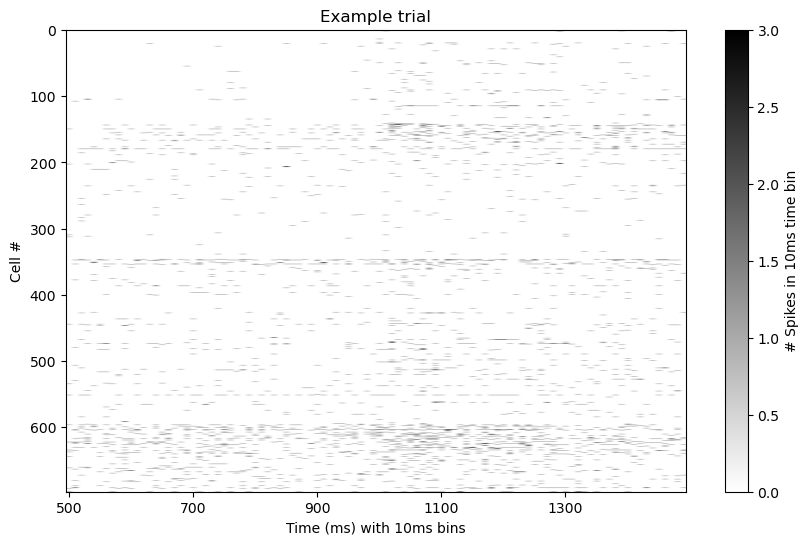

In [10]:
##### Visualise data from one trial
plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xticks([0, 20, 40, 60, 80], [500, 700, 900, 1100, 1300]) 
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 10ms time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [11]:
# batch_size of 34 used to match number of trials
# this will likely change to the number of trials in a different recording
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [20]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.003
num_heads = 4
dropout = 0.1
number_of_epochs = 10000
BERT_number_of_epochs = 420

In [13]:
print(hidden_size)
print(input_size)
print(output_size)

100
698
3


##### Define BERT
BERT still requires time sequence data, here represented by `hidden_size`, which is currently 100 in this data.

In [21]:
# chatgpt 3.5 generated code
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size * 4, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Convert (batch_size, seq_len, hidden_size) to (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Convert back to (batch_size, seq_len, hidden_size)
        x = self.fc(x[:, -1, :])  # Use only the last time step's output for classification
        return self.softmax(x)

##### Train BERT: setup

In [22]:
# chatgpt 3.5 generated code (well, it actually forgot to do this)
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Train BERT and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/10000], Training Loss: 0.57245336, Training Accuracy: 0.9790
Epoch [1/10000], Validation Loss: 1.00732723, Validation Accuracy: 0.5441
Epoch [2/10000], Training Loss: 0.59766345, Training Accuracy: 0.9538
Epoch [2/10000], Validation Loss: 1.00732723, Validation Accuracy: 0.5441
Epoch [3/10000], Training Loss: 0.58926008, Training Accuracy: 0.9622
Epoch [3/10000], Validation Loss: 1.00732723, Validation Accuracy: 0.5441
Epoch [4/10000], Training Loss: 0.58505841, Training Accuracy: 0.9664
Epoch [4/10000], Validation Loss: 1.00732723, Validation Accuracy: 0.5441
Epoch [5/10000], Training Loss: 0.58843385, Training Accuracy: 0.9622
Epoch [5/10000], Validation Loss: 1.00732723, Validation Accuracy: 0.5441
Epoch [6/10000], Training Loss: 0.58926008, Training Accuracy: 0.9622
Epoch [6/10000], Validation Loss: 0.97819844, Validation Accuracy: 0.5735
Epoch [7/10000], Training Loss: 0.56825168, Training Accuracy: 0.9832
Epoch [7/10000], Validation Loss: 0.94859505, Validation Accuracy:

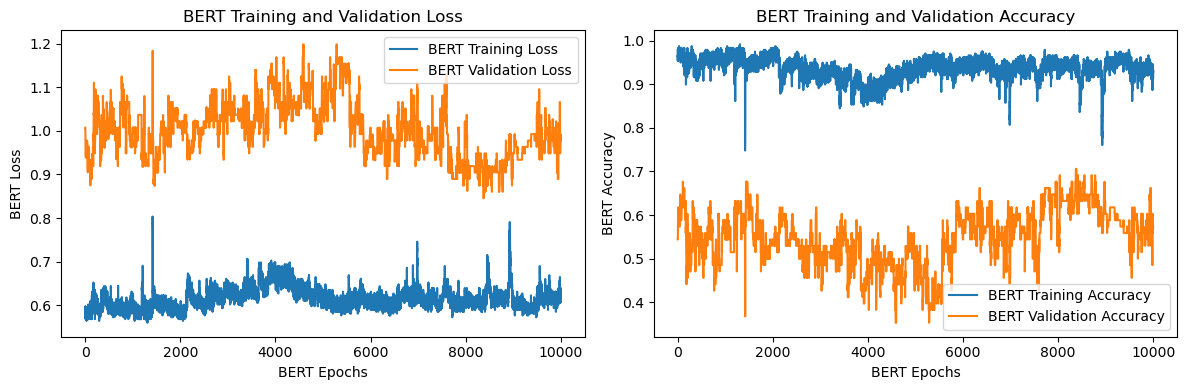

In [24]:
# chatgpt 3.5 generated code
# Training loop
BERT_total_epochs = number_of_epochs
# BERT_total_epochs = BERT_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
BERT_train_losses = []  
BERT_val_losses = []    
BERT_train_accuracies = []  
BERT_val_accuracies = []    

for epoch in range(BERT_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    BERT_train_losses.append(average_train_loss)
    BERT_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{BERT_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    BERT_val_losses.append(average_val_loss)
    BERT_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{BERT_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
BERT_x_epochs = list(range(1, BERT_total_epochs + 1))

plt.figure(figsize=(12, 4))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(BERT_x_epochs, BERT_train_losses, label='BERT Training Loss')
plt.plot(BERT_x_epochs, BERT_val_losses, label='BERT Validation Loss')
plt.xlabel('BERT Epochs')
plt.ylabel('BERT Loss')
plt.title('BERT Training and Validation Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(BERT_x_epochs, BERT_train_accuracies, label='BERT Training Accuracy')
plt.plot(BERT_x_epochs, BERT_val_accuracies, label='BERT Validation Accuracy')
plt.xlabel('BERT Epochs')
plt.ylabel('BERT Accuracy')
plt.title('BERT Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Testing 

In [25]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.4118


##### Analysis BERT
Execution time for 10000 epochs on RTX 3090: 3m 57.4s and test accuracy of 0.4118 at 10000 epochs.

Training and validation losses are all over the map, which isn't surprising given the cheap and dirty implementation given to BERT here. The test accuracy of 0.4418 pretty much sums it up. BERT is going to require more research.